# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** and **Chapter 4 - Beyond Classical Search** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [1]:
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map2, final_path_colors, display_visual2, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

In [3]:
from utils import distance_squared

class GraphProblem(Problem):

	"""The problem of searching a graph from one node to another."""

	def __init__(self, initial, goal, graph):
		Problem.__init__(self, initial, goal)
		self.graph = graph

	def actions(self, A):
		"""The actions at a graph node are just its neighbors."""
		return list(self.graph.get(A).keys())

	def result(self, state, action):
		"""The result of going to a neighbor is just that neighbor."""
		return action

	def path_cost(self, cost_so_far, A, action, B):
		return cost_so_far + (self.graph.get(A, B) or infinity)

	def find_min_edge(self):
		"""Find minimum value of edges."""
		m = infinity
		for d in self.graph.graph_dict.values():
			local_min = min(d.values())
			m = min(m, local_min)

		return m

	def h(self, node):
		#print(node)
		"""h function is straight-line distance from a node's state to goal."""
		locs = getattr(self.graph, 'locations', None)
		if locs:
			if type(node) is str:
				return int(distance_squared(locs[node], locs[self.goal]))

			return int(distance_squared(locs[node.state], locs[self.goal]))
		else:
			return infinity

In [4]:
WALL_TILE = 1
EMPTY_TILE = 0

def build_grid_row(r):
	left_wall = int(r > 20)
	right_wall = int(r <= 40)

	# the grid is 61x61
	if (r == 0 or r == 60):
		return [WALL_TILE] * 61
	else:
		return [WALL_TILE] + ([EMPTY_TILE] * 19) + [left_wall] + ([EMPTY_TILE] * 19) + [right_wall] + ([EMPTY_TILE] * 19) + [WALL_TILE]

def get_node_name(x, y):
	return '{0:0>2}x{1:0>2}'.format(x, y)

def build_graph():
	grid = [build_grid_row(r) for r in range(0, 61)]
	locations = {}
	dict_graph = {}

	for x in range(61):
		for y in range(61):
			locations[get_node_name(x, y)] = (x, 60 - y)

			if (grid[y][x] == WALL_TILE):
				continue;

			valid_neighbors = {}
			for xx in range(x - 1, x + 2):
				for yy in range(y - 1, y + 2):
					if (xx < 0 or xx > 60 or yy < 0 or yy > 60):
						continue;

					if (xx == x and yy == y):
						continue;

					if (grid[yy][xx] == WALL_TILE):
						continue;

					valid_neighbors[get_node_name(xx, yy)] = 1

			dict_graph[get_node_name(x, y)] = valid_neighbors

	graph = UndirectedGraph(dict_graph)
	graph.locations = locations

	return graph

In [5]:
prob = GraphProblem('50x10', '10x50', build_graph())
prob_locations = prob.graph.locations

In [6]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in prob_locations.keys()}
node_positions = prob.graph.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in prob_locations.items() }
edge_weights = {(k, k2) : v2 for k, v in prob.graph.graph_dict.items() for k2, v2 in v.items()}

node_colors['12x41'] = 'darkcyan'
node_colors['10x50'] = 'gold'

prob_graph_data = {  'graph_dict' : prob.graph.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }


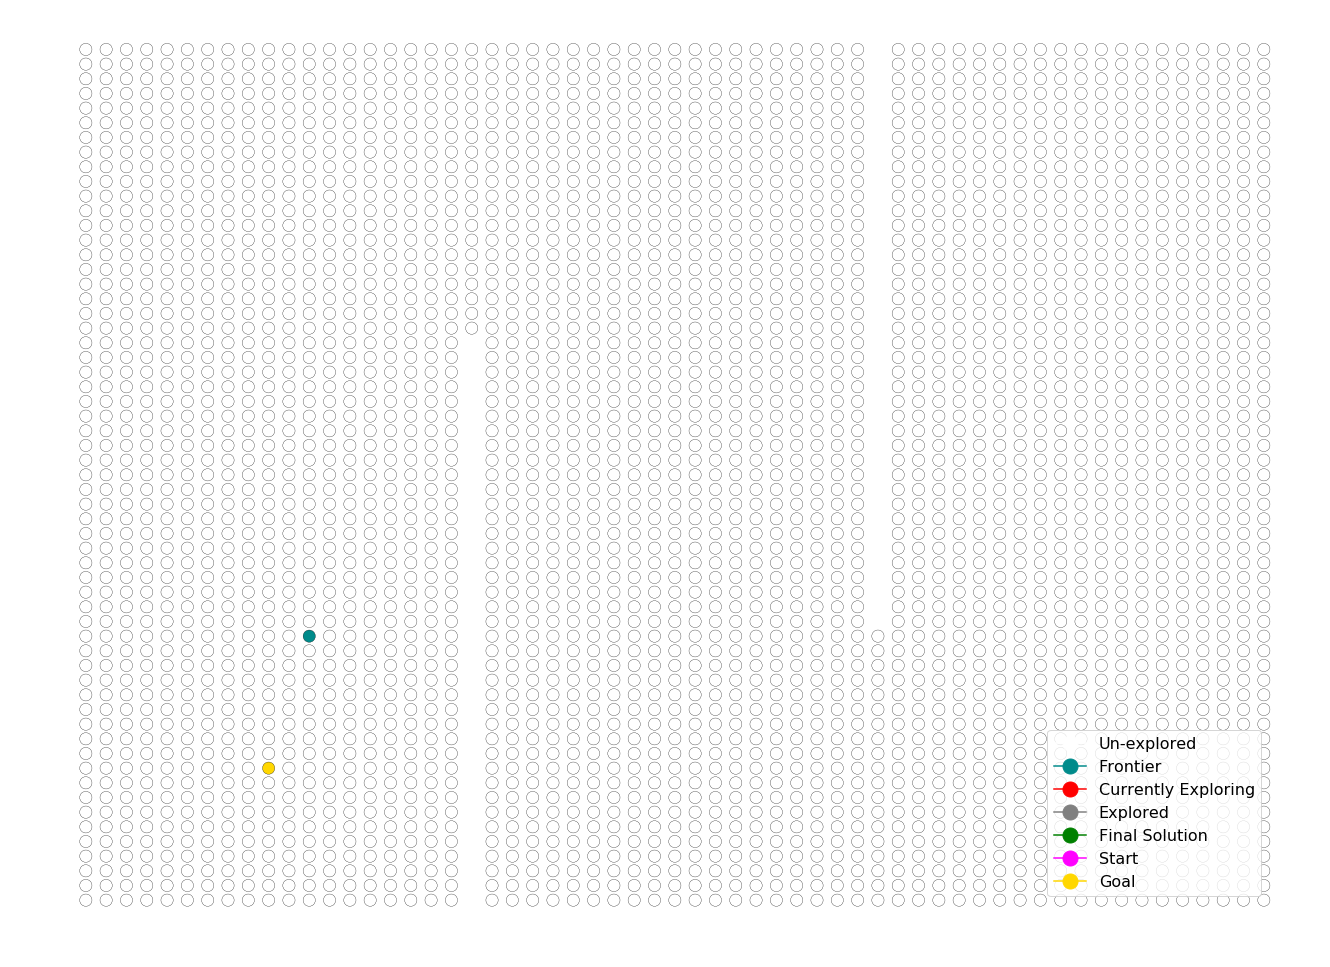

In [7]:
show_map2(prob_graph_data)

In [8]:
def breadth_first_search_graph(problem):
	"[Figure 3.11]"

	# we use these two variables at the time of visualisations
	iterations = 0
	all_node_colors = []
	node_colors = {k : 'white' for k in problem.graph.nodes()}

	node_colors[Node(problem.initial).state] = 'fuchsia'
	node_colors[Node(problem.goal).state] = 'gold'

	node = Node(problem.initial)

	node_colors[node.state] = "red"
	iterations += 1
	all_node_colors.append(dict(node_colors))

	if problem.goal_test(node.state):
		node_colors[node.state] = "green"
		iterations += 1
		all_node_colors.append(dict(node_colors))
		return(iterations, all_node_colors, node)

	frontier = deque([node])

	# modify the color of frontier nodes to blue
	node_colors[node.state] = "orange"
	iterations += 1
	all_node_colors.append(dict(node_colors))

	explored = set()
	while frontier:
		node = frontier.popleft()
		node_colors[node.state] = "red"
		iterations += 1
		all_node_colors.append(dict(node_colors))

		explored.add(node.state)

		for child in node.expand(problem):
			if child.state not in explored and child not in frontier:
				if problem.goal_test(child.state):
					node_colors[child.state] = "green"
					iterations += 1
					all_node_colors.append(dict(node_colors))
					return(iterations, all_node_colors, child)
				frontier.append(child)

				node_colors[child.state] = "darkcyan"
				iterations += 1
				all_node_colors.append(dict(node_colors))

		node_colors[node.state] = "gray"
		iterations += 1
		all_node_colors.append(dict(node_colors))
	return None


In [9]:
all_node_colors = []
prob = GraphProblem('50x10', '10x50', build_graph())
display_visual2(prob_graph_data, user_input=False, 
				algorithm=breadth_first_search_graph, 
				problem=prob)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

In [10]:
def graph_search_for_vis(problem):
	"""Search through the successors of a problem to find a goal.
	The argument frontier should be an empty queue.
	If two paths reach a state, only use the first one. [Figure 3.7]"""
	# we use these two variables at the time of visualisations
	iterations = 0
	all_node_colors = []
	node_colors = {k : 'white' for k in problem.graph.nodes()}

	node_colors[Node(problem.initial).state] = 'fuchsia'
	node_colors[Node(problem.goal).state] = 'gold'

	frontier = [(Node(problem.initial))]
	explored = set()

	# modify the color of frontier nodes to orange
	node_colors[Node(problem.initial).state] = "darkcyan"
	iterations += 1
	all_node_colors.append(dict(node_colors))

	while frontier:
		# Popping first node of stack
		node = frontier.pop()

		# modify the currently searching node to red
		node_colors[node.state] = "red"
		iterations += 1
		all_node_colors.append(dict(node_colors))

		if problem.goal_test(node.state):
			# modify goal node to green after reaching the goal
			node_colors[node.state] = "green"
			iterations += 1
			all_node_colors.append(dict(node_colors))
			return(iterations, all_node_colors, node)

		explored.add(node.state)
		frontier.extend(child for child in node.expand(problem)
						if child.state not in explored and
						child not in frontier)

		for n in frontier:
			# modify the color of frontier nodes to darkcyan
			if (node_colors[n.state] != "darkcyan"):
				node_colors[n.state] = "darkcyan"
				iterations += 1
				all_node_colors.append(dict(node_colors))

		# modify the color of explored nodes to gray
		node_colors[node.state] = "gray"
		iterations += 1
		all_node_colors.append(dict(node_colors))

	return None

def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = graph_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [11]:
all_node_colors = []
prob = GraphProblem('50x10', '10x50', build_graph())
display_visual2(prob_graph_data, user_input=False, 
				algorithm=depth_first_graph_search, 
				problem=prob)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

In [12]:
def best_first_graph_search_for_vis(problem, f):
	"""Search the nodes with the lowest f scores first.
	You specify the function f(node) that you want to minimize; for example,
	if f is a heuristic estimate to the goal, then we have greedy best
	first search; if f is node.depth then we have breadth-first search.
	There is a subtlety: the line "f = memoize(f, 'f')" means that the f
	values will be cached on the nodes as they are computed. So after doing
	a best first search you can examine the f values of the path returned."""

	# we use these two variables at the time of visualisations
	iterations = 0
	all_node_colors = []
	node_colors = {k : 'white' for k in problem.graph.nodes()}

	node_colors[Node(problem.initial).state] = 'fuchsia'
	node_colors[Node(problem.goal).state] = 'gold'

	f = memoize(f, 'f')
	node = Node(problem.initial)
	
	node_colors[node.state] = "red"
	iterations += 1
	all_node_colors.append(dict(node_colors))

	if problem.goal_test(node.state):
		node_colors[node.state] = "green"
		iterations += 1
		all_node_colors.append(dict(node_colors))
		return(iterations, all_node_colors, node)

	frontier = PriorityQueue('min', f)
	frontier.append(node)

	node_colors[node.state] = "darkcyan"
	iterations += 1
	all_node_colors.append(dict(node_colors))

	explored = set()
	while frontier:
		node = frontier.pop()

		node_colors[node.state] = "red"
		iterations += 1
		all_node_colors.append(dict(node_colors))

		if problem.goal_test(node.state):
			node_colors[node.state] = "green"
			iterations += 1
			all_node_colors.append(dict(node_colors))
			return (iterations, all_node_colors, node)

		explored.add(node.state)
		for child in node.expand(problem):
			if child.state not in explored and child not in frontier:
				frontier.append(child)
				node_colors[child.state] = "darkcyan"
				iterations += 1
				all_node_colors.append(dict(node_colors))

			elif child in frontier:
				if f(child) < frontier[child]:
					del frontier[child]
					frontier.append(child)
					node_colors[child.state] = "darkcyan"
					iterations += 1
					all_node_colors.append(dict(node_colors))

		node_colors[node.state] = "gray"
		iterations += 1
		all_node_colors.append(dict(node_colors))
	return None



	"""Search the nodes with the lowest f scores first.
	You specify the function f(node) that you want to minimize; for example,
	if f is a heuristic estimate to the goal, then we have greedy best
	first search; if f is node.depth then we have breadth-first search.
	There is a subtlety: the line "f = memoize(f, 'f')" means that the f
	values will be cached on the nodes as they are computed. So after doing
	a best first search you can examine the f values of the path returned."""

	# we use these two variables at the time of visualisations
	iterations = 0
	all_node_colors = []
	node_colors = {k : 'white' for k in problem.graph.nodes()}

	node_colors[Node(problem.initial).state] = 'fuchsia'
	node_colors[Node(problem.goal).state] = 'gold'

	f = memoize(f, 'f')
	node = Node(problem.initial)

	node_colors[node.state] = "red"
	iterations += 1
	all_node_colors.append(dict(node_colors))

	if problem.goal_test(node.state):
		node_colors[node.state] = "green"
		iterations += 1
		all_node_colors.append(dict(node_colors))
		return(iterations, all_node_colors, node)

	frontier = PriorityQueue('min', f)
	frontier.append(node)

	node_colors[node.state] = "darkcyan"
	iterations += 1
	all_node_colors.append(dict(node_colors))

	explored = set()
	while frontier:
		node = frontier.pop()

		node_colors[node.state] = "red"
		iterations += 1
		all_node_colors.append(dict(node_colors))

		if problem.goal_test(node.state):
			node_colors[node.state] = "green"
			iterations += 1
			all_node_colors.append(dict(node_colors))
			return(iterations, all_node_colors, node)

		explored.add(node.state)
		for child in node.expand(problem):
			if child.state not in explored and child not in frontier:
				frontier.append(child)
				print("Appending1 " + str(child))
				node_colors[child.state] = "darkcyan"
				iterations += 1
				all_node_colors.append(dict(node_colors))
			elif child in frontier:
				print(child)
				print(frontier.queue)
				print(frontier.queue[child])
				incumbent = frontier[child]
				print(incumbent)
				if f(child) < f(incumbent):
					del frontier[incumbent]
					print("Appending2 " + str(child))
					frontier.append(child)
					node_colors[child.state] = "darkcyan"
					iterations += 1
					all_node_colors.append(dict(node_colors))

		node_colors[node.state] = "gray"
		iterations += 1
		all_node_colors.append(dict(node_colors))
	return None

def greedy_best_first_search(problem, h=None):
	"""Greedy Best-first graph search is an informative searching algorithm with f(n) = h(n).
	You need to specify the h function when you call best_first_search, or
	else in your Problem subclass."""
	h = memoize(h or problem.h, 'h')
	iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda n: h(n))
	return(iterations, all_node_colors, node)

In [13]:
all_node_colors = []
prob = GraphProblem('50x10', '10x50', build_graph())
display_visual2(prob_graph_data, user_input=False, 
				algorithm=greedy_best_first_search, 
				problem=prob)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

In [14]:
def astar_search_graph(problem, h=None):
	"""A* search is best-first graph search with f(n) = g(n)+h(n).
	You need to specify the h function when you call astar_search, or
	else in your Problem subclass."""
	h = memoize(h or problem.h, 'h')
	iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, 
																lambda n: n.path_cost + h(n))
	return(iterations, all_node_colors, node)

In [15]:
all_node_colors = []
prob = GraphProblem('50x10', '10x50', build_graph())
display_visual2(prob_graph_data, user_input=False, 
				algorithm=astar_search_graph, 
				problem=prob)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…